In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import shutil
from tqdm import tqdm
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
import glob
import shutil
from PIL import Image
import pandas as pd

import requests as re
from io import BytesIO

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

PyTorch Version:  2.2.0+cpu
Torchvision Version:  0.17.0+cpu


In [54]:
# Write dataloaders to account for tank type

tank_types = set([i.split('_')[0][6:] for i in glob.glob(f'Tanks/*')])

# get frequency counts of  non-destroyed
 
tank_types_freq = {tank_type : len((set(glob.glob(f'Tanks/*{tank_type}*')) - set(glob.glob(f'Tanks/*destr*')))) for tank_type in tank_types

}

total_tanks = sum(tank_types_freq.values())

tank_types_freq_perc = pd.Series(np.array(list(tank_types_freq.values())) / total_tanks, index = tank_types_freq.keys())
tank_types_freq = pd.Series(tank_types_freq)

# valid non-one shot classes
cutoff = 40

valid_types = tank_types_freq[tank_types_freq > cutoff].index

# remove unkown
valid_types = list(set(valid_types) - {'unknown'})

In [59]:
# make new dataloaders dirs

root_folder = 'tank_types_classifier'

for valid_type in valid_types:
    try:
        os.mkdir(root_folder + '/' + valid_type)
    except:
        pass
    for pic in (set(glob.glob(f'Tanks/*{valid_type}*')) - set(glob.glob(f'Tanks/*destr*'))):
        shutil.copy(pic, root_folder+'/' + valid_type + '/' + pic.split('\\')[-1])


In [81]:
seed = 200

random.seed(seed)

train, valid = train_test_split(glob.glob(f'{root_folder}/*/*'), train_size=0.9, random_state = seed)

# Assign train valid splits to dirs
for phase, phase_str in zip([train, valid], ["train", "valid"]):
    try:
        os.mkdir('tank_types_classifier' + '/' + phase_str)
    except:
        pass
    for file in phase:
        tank_type = file.split('\\')[1]
        file_name = file.split('\\')[2]
        try:
            os.mkdir('tank_types_classifier' + '/' + phase_str + '/' + tank_type)
        except:
            pass
        shutil.copy(file, 'tank_types_classifier' + '/' + phase_str + '/' + 
                    tank_type + '/' + file_name)



In [90]:
# make train test splits
data_dir = root_folder

def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations.

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "valid" keys, each is mapped to a pytorch dataloader.
    """

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # create transform for data
    composed_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std)])


    image_datasets = {
        'train': datasets.ImageFolder(data_dir + '/train', transform=composed_transform),
        'valid': datasets.ImageFolder(data_dir + '/valid', transform=composed_transform)
    }

    class_weights = []
    for _, labels in image_datasets['train']:
        class_weights.append(labels)

    # Compute weights for each sample
    weights = [1.0 / class_weights.count(i) for i in class_weights]

    sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

    

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {
        "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=False, num_workers=2, sampler=sampler),
        "valid": torch.utils.data.DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=False, num_workers=2)
    }

    return dataloaders_dict

In [91]:
batch_size = 16

dataloaders_dict = get_dataloaders(256, batch_size)

['t-72', 't-72a', 't-72b', 't-72b3', 't-80b', 't-80bv', 't-80bvm', 't-80u']


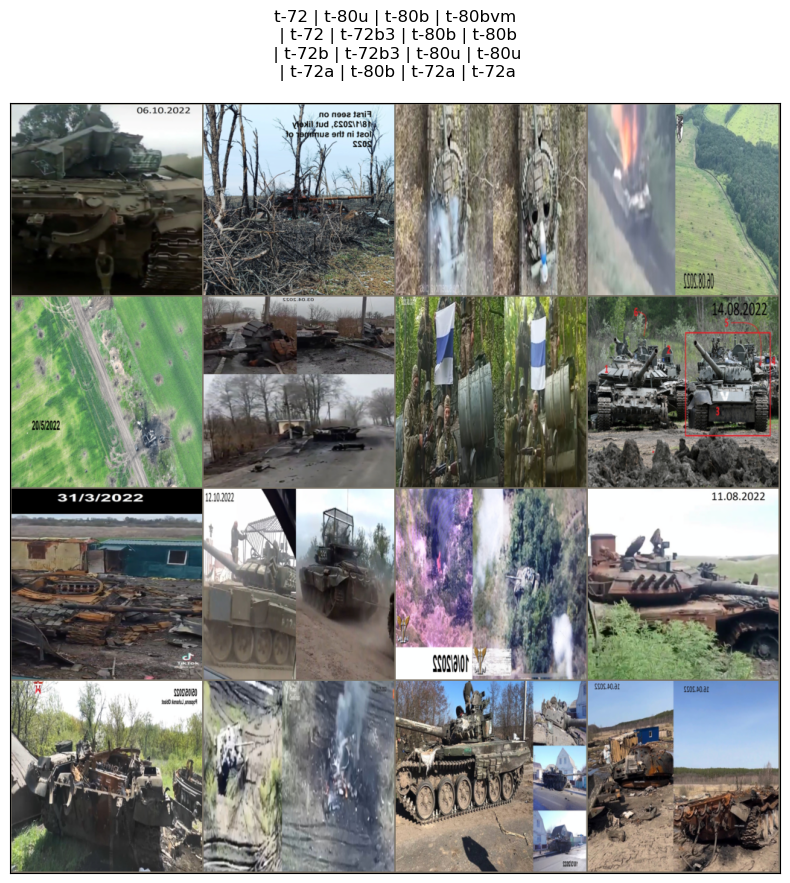

In [92]:
# Visualize the data within the dataset
import json
#with open('./data_miniplaces_modified/category_names.json', 'r') as f:
 #   class_names = json.load(f)['i2c']
#class_names = {i:name for i, name in enumerate(class_names)}
class_dir = "tank_types_classifier/train"
class_names = os.listdir(class_dir)
class_names.sort()
print(class_names)
def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

In [94]:
len(valid_types)

9

In [95]:
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last layer for binary classification
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 9)  # Assuming binary classification, change '2' based on your classes

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Training loop
num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

train_loader = dataloaders_dict['train']

trn_loss = []
trn_accuracy = []
val_loss = []
val_accuracy = []


for epoch in range(num_epochs):
    if epoch % 10 == 0:
        continue_train = input("Continue Train? (y/n): ")
        if continue_train == 'n':
            break

    resnet18.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train

    trn_loss.append(average_loss)
    trn_accuracy.append(accuracy_train)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss (Train): {average_loss:.4f}, Accuracy (Train): {accuracy_train * 100:.2f}%")

    # on validation set
    resnet18.eval()
    correct = 0
    total = 0
    loss_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders_dict['valid']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            loss_valid += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_accuracy = correct / total
    valid_loss = loss_valid / len(dataloaders_dict['valid'])

    val_accuracy.append(valid_accuracy)
    val_loss.append(valid_loss)

    # save model if max validation accuracy
    if valid_accuracy > max(val_accuracy):
        torch.save(resnet18.state_dict(), 'oryx_weights_types/resnet18_tank_classification_max_accuracy.pth')

    print(f"Loss (Valid): {valid_loss:.4f}, Accuracy (Valid): {valid_accuracy * 100:.2f}%")


torch.save(resnet18.state_dict(), 'oryx_weights_types/resnet18_tank_classification.pth')

c:\Users\randymi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\randymi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 119/119 [00:38<00:00,  3.07it/s]


Epoch 1/200, Loss (Train): 2.0919, Accuracy (Train): 18.52%


100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Loss (Valid): 2.3665, Accuracy (Valid): 6.22%


100%|██████████| 119/119 [00:39<00:00,  2.99it/s]


Epoch 2/200, Loss (Train): 1.9508, Accuracy (Train): 26.07%


100%|██████████| 14/14 [00:06<00:00,  2.02it/s]


Loss (Valid): 2.1186, Accuracy (Valid): 16.27%


100%|██████████| 119/119 [00:40<00:00,  2.94it/s]


Epoch 3/200, Loss (Train): 1.8688, Accuracy (Train): 29.34%


100%|██████████| 14/14 [00:07<00:00,  1.92it/s]


Loss (Valid): 2.1082, Accuracy (Valid): 15.31%


100%|██████████| 119/119 [00:40<00:00,  2.90it/s]


Epoch 4/200, Loss (Train): 1.8078, Accuracy (Train): 31.29%


100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


Loss (Valid): 2.0378, Accuracy (Valid): 15.31%


100%|██████████| 119/119 [00:41<00:00,  2.86it/s]


Epoch 5/200, Loss (Train): 1.7868, Accuracy (Train): 32.51%


100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Loss (Valid): 2.1829, Accuracy (Valid): 18.18%


100%|██████████| 119/119 [00:43<00:00,  2.77it/s]


Epoch 6/200, Loss (Train): 1.7490, Accuracy (Train): 34.09%


100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Loss (Valid): 2.4110, Accuracy (Valid): 7.18%


100%|██████████| 119/119 [00:41<00:00,  2.85it/s]


Epoch 7/200, Loss (Train): 1.7294, Accuracy (Train): 35.73%


100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


Loss (Valid): 2.2915, Accuracy (Valid): 14.35%


100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


Epoch 8/200, Loss (Train): 1.6871, Accuracy (Train): 37.52%


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Loss (Valid): 2.3055, Accuracy (Valid): 4.78%


100%|██████████| 119/119 [00:45<00:00,  2.59it/s]


Epoch 9/200, Loss (Train): 1.6488, Accuracy (Train): 38.05%


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Loss (Valid): 2.2293, Accuracy (Valid): 10.05%


100%|██████████| 119/119 [00:45<00:00,  2.60it/s]


Epoch 10/200, Loss (Train): 1.6345, Accuracy (Train): 39.74%


100%|██████████| 14/14 [00:08<00:00,  1.66it/s]


Loss (Valid): 2.2484, Accuracy (Valid): 11.00%


100%|██████████| 119/119 [00:43<00:00,  2.73it/s]


Epoch 11/200, Loss (Train): 1.6189, Accuracy (Train): 39.79%


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Loss (Valid): 2.4435, Accuracy (Valid): 8.61%


100%|██████████| 119/119 [00:43<00:00,  2.73it/s]


Epoch 12/200, Loss (Train): 1.5981, Accuracy (Train): 40.32%


100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


Loss (Valid): 2.3466, Accuracy (Valid): 7.66%


100%|██████████| 119/119 [00:42<00:00,  2.83it/s]


Epoch 13/200, Loss (Train): 1.6157, Accuracy (Train): 40.90%


100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


Loss (Valid): 2.3460, Accuracy (Valid): 9.57%


100%|██████████| 119/119 [00:41<00:00,  2.87it/s]


Epoch 14/200, Loss (Train): 1.5942, Accuracy (Train): 39.47%


100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


Loss (Valid): 2.2900, Accuracy (Valid): 19.14%


100%|██████████| 119/119 [00:42<00:00,  2.81it/s]


Epoch 15/200, Loss (Train): 1.5294, Accuracy (Train): 43.96%


100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Loss (Valid): 2.3531, Accuracy (Valid): 8.61%


100%|██████████| 119/119 [00:41<00:00,  2.85it/s]


Epoch 16/200, Loss (Train): 1.5523, Accuracy (Train): 41.69%


100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


Loss (Valid): 2.3199, Accuracy (Valid): 11.00%


100%|██████████| 119/119 [00:41<00:00,  2.85it/s]


Epoch 17/200, Loss (Train): 1.5227, Accuracy (Train): 44.22%


100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Loss (Valid): 2.3883, Accuracy (Valid): 7.18%


100%|██████████| 119/119 [00:41<00:00,  2.86it/s]


Epoch 18/200, Loss (Train): 1.5516, Accuracy (Train): 41.53%


100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Loss (Valid): 2.2941, Accuracy (Valid): 15.79%


100%|██████████| 119/119 [00:42<00:00,  2.78it/s]


Epoch 19/200, Loss (Train): 1.4996, Accuracy (Train): 44.75%


100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


Loss (Valid): 2.4355, Accuracy (Valid): 10.53%


100%|██████████| 119/119 [00:42<00:00,  2.83it/s]


Epoch 20/200, Loss (Train): 1.4962, Accuracy (Train): 44.43%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 2.4252, Accuracy (Valid): 6.70%


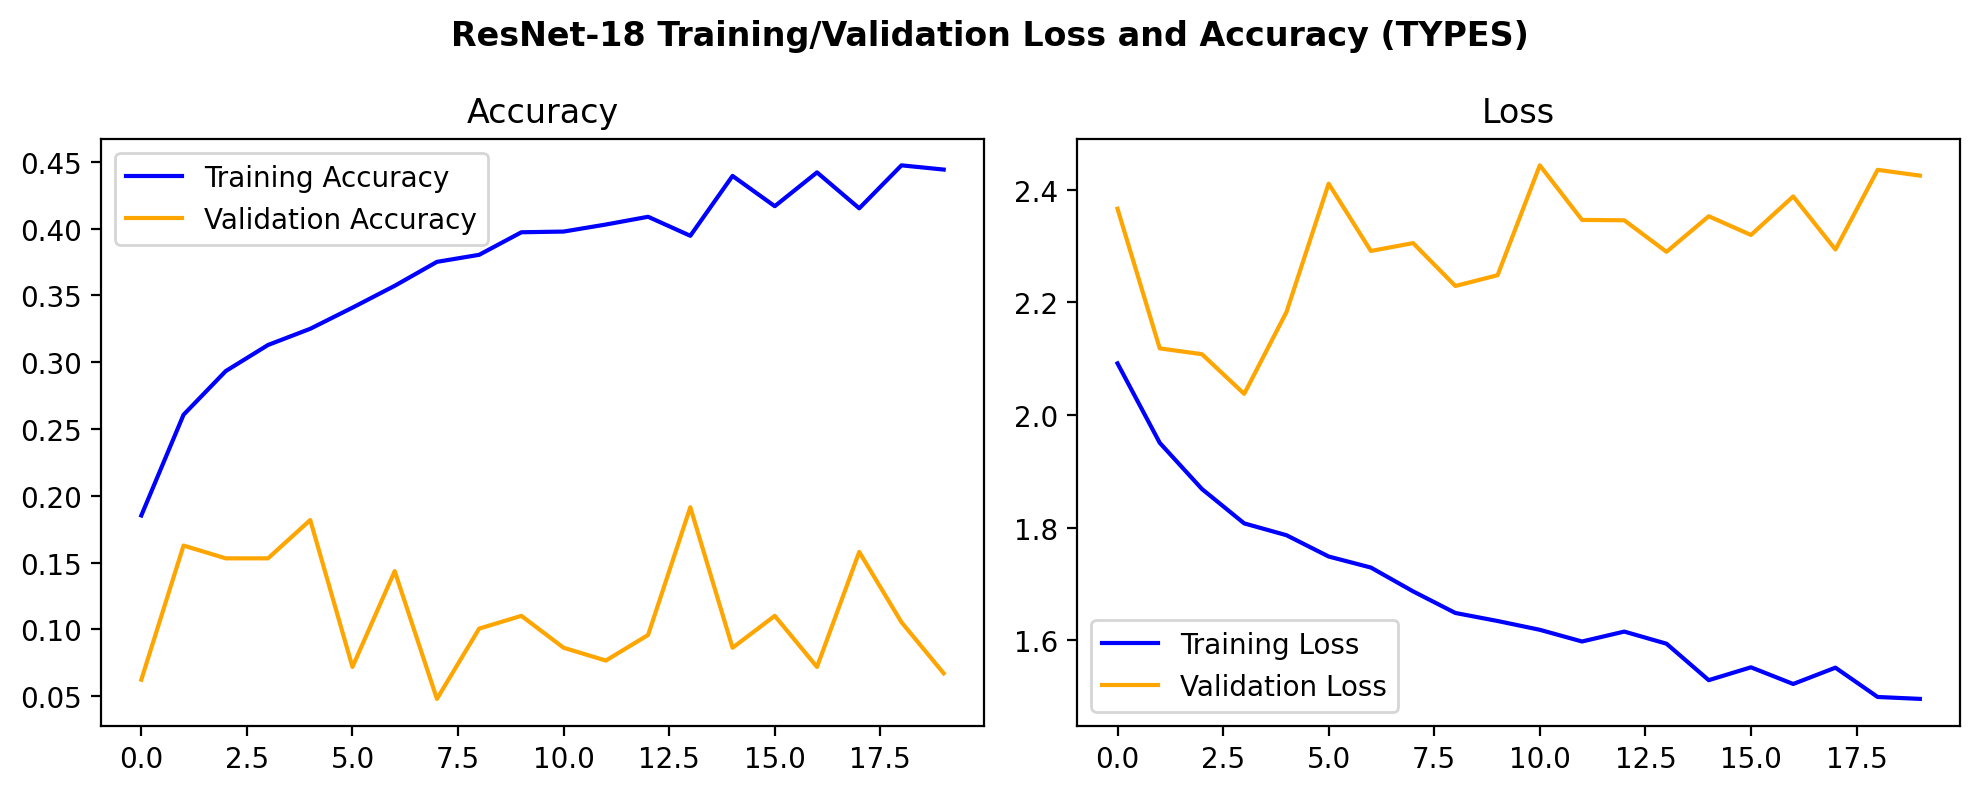

In [96]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot on the first subplot
axes[0].plot(trn_accuracy, label='Training Accuracy', color='blue')
axes[0].plot(val_accuracy, label='Validation Accuracy', color='orange')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot on the second subplot
axes[1].plot(trn_loss, label='Training Loss', color='blue')
axes[1].plot(val_loss, label='Validation Loss', color='orange')
axes[1].set_title('Loss')
axes[1].legend()

fig.suptitle("ResNet-18 Training/Validation Loss and Accuracy (TYPES)", fontweight = 'bold')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

fig.savefig('resnet18_training_validation_loss_accuracy_types.png')

1. overfitting. add dropout layers, maybe try resnet32
2. poor training loss progression after epoch 13. increase batch size
3. modify train_test_split to 80/20